# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 05**: Data pipeline with Neo4j

**Date**: October 4nd 2025

**Student Name**: Luis Angel Santana Hernandez

**Professor**: Pablo Camarillo Ramirez

# Dataset description

The dataset represents the Fine Foods product reviews on the Amazon website. It contains the review data, the users who wrote the reviews, and the products the reviews are directed at.
With this information, we will create two types of nodes and one relationship:

1. Nodes representing the users.

2. Nodes representing the products.

3. Relationships representing the reviews, which connect a user (source) to a product (destination) and include the review data as attributes.

# Data ingestion

In [37]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [38]:
# Build schema
from luis_santana.spark_utils import SparkUtils
reviews_schema = SparkUtils.generate_schema([("id", "int"), ("ProductId","string"), ("UserId","string"), ("ProfileName","string"), ("HelpfulnessNumerator","int"), ("HelpfulnessDenominator","int"), ("Score","int"), ("Time","int"), ("Summary","string"), ("Text","string")])
# Import your module
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?select=database.sqlite
base_path = "/opt/spark/work-dir/data/"
df_airlines = spark.read \
                .option("header", "true") \
                .schema(reviews_schema) \
                .csv(base_path + "/food/Reviews.csv")

#limit 5000: the data was to much for my laptop so I limit to 5000 of the original 568454
df_airlines = df_airlines.limit(5000)

#clean data
df_airlines_clean = df_airlines.dropna(how='any')
df_airlines_clean = df_airlines_clean.dropDuplicates()

#show data
df_airlines_clean.show()


+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl|            

# Transformations

In [39]:
# Add the code for your transformations to create nodes and edges DataFrames HERE
from pyspark.sql.functions import col

# --- NODES ---
Users_node = df_airlines_clean.select(col("UserId").alias("id"), "ProfileName").dropDuplicates(["id"])
Users_node.show()

Products_node = df_airlines_clean.select(col("ProductId").alias("id")).dropDuplicates(["id"])
Products_node.show()


# --- EDGES ---
Reviews_node = df_airlines_clean.select("id", col("ProductId").alias("dst"), col("UserId").alias("src"),"Score","Summary","Text").dropDuplicates(["id"])
Reviews_node.show()


+--------------+--------------------+
|            id|         ProfileName|
+--------------+--------------------+
|A102XKYZE9Q9L4|"TjB ""cancer-fre...|
|A10317LUD1C1VJ|                 CSN|
|A103EZCS9H8WW1|Shirena Nicole Go...|
|A103U3KR4L2ZXT|"AndreaR ""andiem...|
|A104Y49ZQ4CYJ2|"H. Adams ""holly...|
|A105FP1ZT88EPL|           david lee|
|A106R36BNKKMCO|        Gem Morrison|
| A107MO1RZUQ8V|        Italian Girl|
|A107SVKYGPGBPP|     Angle Side Side|
|A108GQ9A91JIP4|           H Hulsing|
|A108P30XVUFKXY|           Roberto A|
|A10AFVU66A79Y1|"R. Cipriani ""Fl...|
|A10APXLM7P5P0G|NO WORLD ORDER- W...|
|A10B89QOKDV5O3|            Jamie F.|
|A10CF04CJZC05F|"Suzanne ""Suzann...|
|A10E57QZ4GJ32F|            Sharks77|
|A10EHUTGNC4BGP|            M. Foell|
|A10EII7MQD4N28|             SunFire|
|A10IFYN5U6X20R|            onemagoo|
|A10JAUM70F9M8U|        Kari L. Kail|
+--------------+--------------------+
only showing top 20 rows


+----------+
|        id|
+----------+
|B001E4KFG0|
|B00813GRG4|
|B000LQOCH0|
|B000UA0QIQ|
|B006K2ZZ7K|
|B000E7L2R4|
|B00171APVA|
|B0001PB9FE|
|B0009XLVG0|
|B001GVISJM|
|B00144C10S|
|B0001PB9FY|
|B003F6UO7K|
|B001EO5QW8|
|B000G6RPMY|
|B002GWHC0G|
|B004N5KULM|
|B001EO5TPM|
|B005DUM9UQ|
|B000E7VI7S|
+----------+
only showing top 20 rows


+---+----------+--------------+-----+--------------------+--------------------+
| id|       dst|           src|Score|             Summary|                Text|
+---+----------+--------------+-----+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|    5|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|    1|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|    4|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|    2|      Cough Medicine|If you are lookin...|
|  5|B006K2ZZ7K|A1UQRSCLF8GW1T|    5|         Great taffy|Great taffy at a ...|
|  6|B006K2ZZ7K| ADT0SRK1MGOEU|    4|          Nice Taffy|I got a wild hair...|
|  7|B006K2ZZ7K|A1SP2KVKFXXRU1|    5|Great!  Just as g...|This saltwater ta...|
|  8|B006K2ZZ7K|A3JRGQVEQN31IQ|    5|Wonderful, tasty ...|This taffy is so ...|
|  9|B000E7L2R4|A1MZYO9TZK0BBI|    5|          Yay Barley|Right now I'm mos...|
| 10|B00171APVA|A21BT40VZCCYT4|    5|   

# Writing Data in Neo4j

In [40]:
# Add the code to write a graph from PySpark's DataFrames to Neo4j
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

Users_node.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Users") \
  .option("node.keys", "id") \
  .save()

print(f"{Users_node.count()} users wrote in Neo4j")


Products_node.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Product") \
  .option("node.keys", "id") \
  .save()

print(f"{Products_node.count()} product nodes wrote in Neo4j")


# --- EDGES ---
Reviews_node.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("relationship", "REVIEWED") \
  .option("relationship.save.strategy", "keys") \
  .option("relationship.source.labels", ":Users") \
  .option("relationship.source.save.mode", "match") \
  .option("relationship.source.node.keys", "src:id") \
  .option("relationship.target.labels", ":Product") \
  .option("relationship.target.save.mode", "match") \
  .option("relationship.target.node.keys", "dst:id") \
  .save()
print(f"{Reviews_node.count()} REVIEWED edges wrote in Neo4j")

4784 users wrote in Neo4j


729 product nodes wrote in Neo4j


4979 REVIEWED edges wrote in Neo4j


# Read and Query Graphs with PySpark

In [41]:
# Add the code to read a data frame from Neo4J and run a simple query to verify 
user_table = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            match (u:Users)
            return u.id as userId, u.ProfileName as profileName
            """
            )\
    .load()

user_table.show()

+--------------+--------------------+
|        userId|         profileName|
+--------------+--------------------+
|A2IGNVVY8NY3L1|                 Peg|
|A2II09GQGWOMTQ|"Brian Nallick ""...|
|A2II54B3VA45LN|Professional shopper|
|A2IJOBHJXEZSS2|            mosslake|
|A2IK64NEJ895W2|            S. Coats|
|A2IKWKIW5OS5CM|             Heidi J|
|A2INEVLD3SNCUC|"Lisa Ann Welker ...|
|A2IO81VHTFEYN8|         Patricia T.|
|A2IOH181X1SZ3S|           A. Dapice|
|A2IOTFFGCHHDKU|"Minnie Mouse ""s...|
|A2IRN7AVMV5PPL|               Louis|
|A2ISKAWUPGGOLZ|       M. S. Handley|
|A2ITY3O2UPJLN8|        J. Alec West|
|A2IWN2E52HLQWA|"Margaret W. Finl...|
|A2IX1B76ONTXEL|          Cinderella|
|A2J0QB01UVSH0Q|    Trishelle Duncan|
|A2J1EGNKT7I82I|                 LLK|
|A2J1J9S1DG5IXX|               Diane|
|A2J2UBSUZ81QWL|"covert camper ""...|
|A2J3CWYRKKY59X|"L. Manlief ""bel...|
+--------------+--------------------+
only showing top 20 rows


In [42]:
product_table = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            match (p:Product)
            return p.id as productId
            """
            )\
    .load()
product_table.show()

+----------+
| productId|
+----------+
|B001E4KFG0|
|B00813GRG4|
|B000LQOCH0|
|B000UA0QIQ|
|B006K2ZZ7K|
|B000E7L2R4|
|B00171APVA|
|B0001PB9FE|
|B0009XLVG0|
|B001GVISJM|
|B00144C10S|
|B0001PB9FY|
|B003F6UO7K|
|B001EO5QW8|
|B000G6RPMY|
|B002GWHC0G|
|B004N5KULM|
|B001EO5TPM|
|B005DUM9UQ|
|B000E7VI7S|
+----------+
only showing top 20 rows


In [43]:
union_tables = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            match (u:Users)-[r:REVIEWED]->(p:Product)
            return u.id as userId, u.ProfileName as profileName, p.id as productId, r.Score as score, r.Summary as summary, r.Text as text
            """
            )\
    .load()

union_tables.show()

+--------------+--------------------+----------+-----+--------------------+--------------------+
|        userId|         profileName| productId|score|             summary|                text|
+--------------+--------------------+----------+-----+--------------------+--------------------+
|A3SGXH7AUHU8GW|          delmartian|B001E4KFG0|    5|Good Quality Dog ...|I have bought sev...|
|A1D87F6ZCVE5NK|              dll pa|B00813GRG4|    1|   Not as Advertised|"Product arrived ...|
| ABXLMWJIXXAIN|"Natalia Corres "...|B000LQOCH0|    4|"""Delight"" says...|"This is a confec...|
|A395BORC6FGVXV|                Karl|B000UA0QIQ|    2|      Cough Medicine|If you are lookin...|
|A3JRGQVEQN31IQ|  Pamela G. Williams|B006K2ZZ7K|    5|Wonderful, tasty ...|This taffy is so ...|
|A1SP2KVKFXXRU1|   David C. Sullivan|B006K2ZZ7K|    5|Great!  Just as g...|This saltwater ta...|
| ADT0SRK1MGOEU|      Twoapennything|B006K2ZZ7K|    4|          Nice Taffy|I got a wild hair...|
|A1UQRSCLF8GW1T|"Michael D. Bi

In [44]:
# reviews from product B001GVISJM
reviews_B001GVISJM = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            match (u:Users)-[r:REVIEWED]->(p:Product {id: 'B001GVISJM'})
            return u.id as userId, u.ProfileName as profileName, r.Score as score, r.Summary as summary, r.Text as text
            """
            )\
    .load()

reviews_B001GVISJM.show()

+--------------+--------------------+-----+--------------------+--------------------+
|        userId|         profileName|score|             summary|                text|
+--------------+--------------------+-----+--------------------+--------------------+
| AAAS38B98HMIK|        Heather Dube|    4|Great Bargain for...|I was so glad Ama...|
|A3RXAU2N8KV45G|              lady21|    1|     Nasty No flavor|The candy is just...|
|A3FONPR03H3PJS|"Deborah S. Linze...|    5|Twizzlers - Straw...|"Product received...|
|A22P2J09NJ9HKE|"S. Cabanaugh ""j...|    5|Please sell these...|I have lived out ...|
| AJ613OLZZUG7V|              Mare's|    5|           Twizzlers|I love this candy...|
| ARYVQL4N737A1|       Charles Brown|    5|  Delicious product!|I can remember bu...|
| AZOF9E17RGZH8|      Tammy Anderson|    5|           TWIZZLERS|"I bought these f...|
|A1WO0KGLPR5PV6|            mom2emma|    5|        Always fresh|My husband is a T...|
|A3IV7CL2C13K2U|                Greg|    5|Home delive

# Image in Neo4j


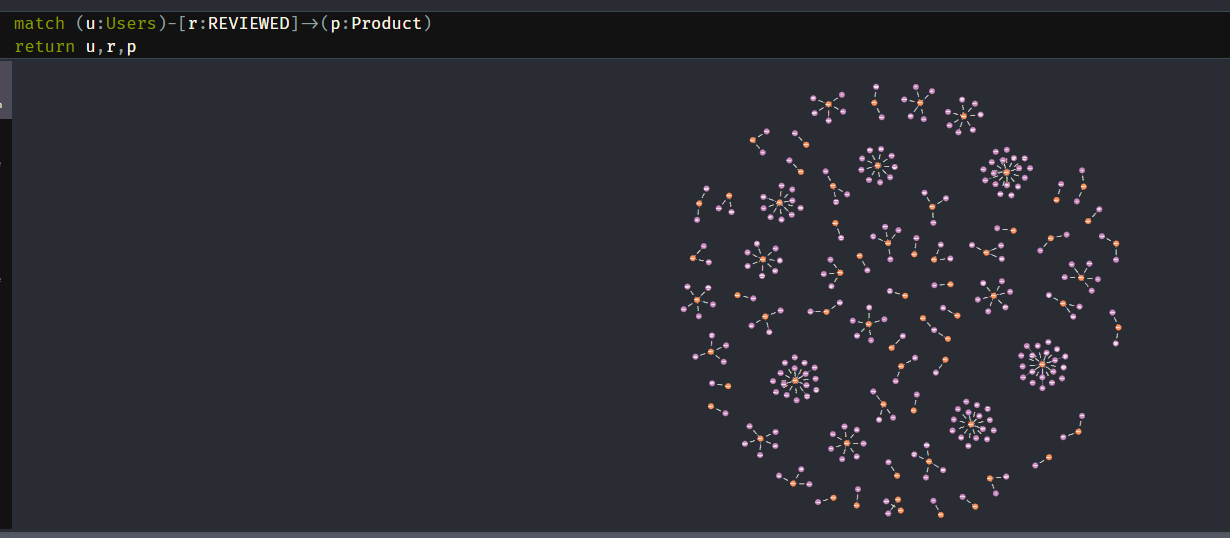

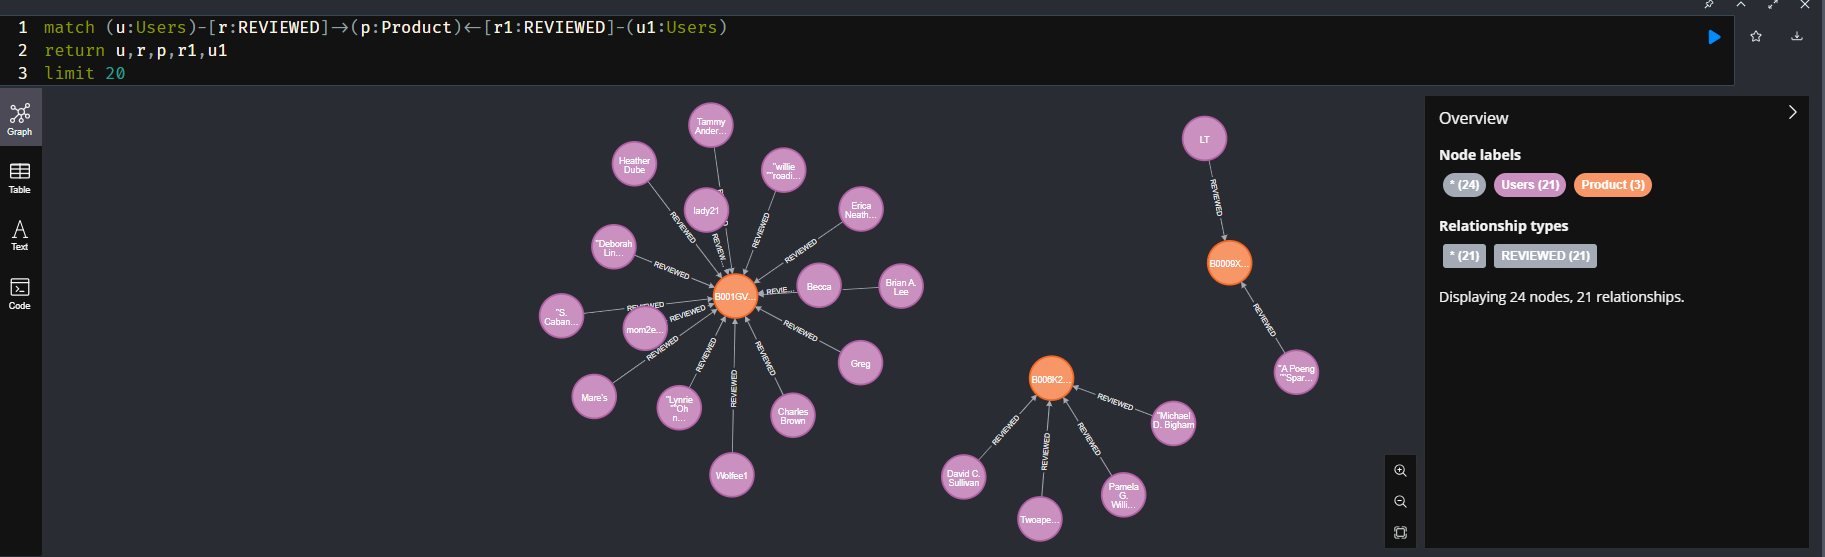

In [45]:
sc.stop()